# Observational Realism Suite

## Examples

### Example 1: SDSS statistical observational realism in gri bands

In this example, you will use the use the statistical observational realism described in Bottrell et al (2017a) and made public in Bottrell et al (2019b) to insert a handful of galaxy images quasi-randomly into real SDSS fields. The inputs (found in the Inputs directory) are synthetic idealized photometry images. These images are noiseless with an extraordinarily high resolution spatial resolution (97 pc/pixel). The final image is in AB nanomaggies, a calibrated flux unit. It includes real sky, real PSF degradation, and contamination by additional sources in the field of view. Most importantly, the statistics for these properties match those for real SDSS galaxies. All of the information about the fields in which these images are inserted is included in the image headers, along with all of the user-defined specifics.

The images are generated from the G2G3e orbit1 merger from the Moreno et al (2019) merger suite. The images were produced from SKIRT datacubes generated by Maan Hani (University of Victoria). We use the quantitative morphologies catalog of Simard et al (2011) as the basis catalog for the insertion statistics.




In [1]:
from ObsRealism import *
from astropy.io import fits
import numpy as np
import os,sys

# base path to input images
img_base_path = 'Inputs/'
# configuration path (SExtractor params, gim2d files, etc.)
sdss_cfg_path = 'Sources/utils/sdss-cfg/'
# application path (read_PSF, read_atlas, etc.)
sdss_app_path = 'Sources/utils/sdss-apps/'
# output directory path
output_type = 'FullReal'
output_path = 'Outputs/'
useSQL = False

if useSQL:
    import pymysql
    table = 'sdss_dr7_morph_mybkg_mydeblend_gr'
    db = pymysql.connect(host='localhost',db='sdss',password='your_pass')
    c = db.cursor()
    dbcmd = ['SELECT run,rerun,camcol,field',
             'FROM {}'.format(table)]
    c.execute(' '.join(dbcmd))
    field_info = np.asarray(c.fetchall()).astype(int)
    c.close()
    db.close()
else:
    field_info = np.load('Sources/Simard2011_Field_Info.npy')

# '''
# These common args adopt a redshift of z=0.046 (only used to determine the 
# physical to angular scale [kpc/arcsec]). With rebin_to_CCD=True, the input
# image is rebinned to a CCD scale set by 'CCD_scale' (which in this case is
# the 0.396 arcsec/pixel of the SDSS camera. The images are added to real
# image fields and incorporate a reconstruction of the real SDSS PSF. Poisson
# noise is added to the image.
# '''

common_args = { 
                'redshift'      : 0.05,  # mock observation redshift
                'rebin_to_CCD'  : True,  # rebin to CCD angular scale
                'CCD_scale'     : 0.396, # CCD angular scale in [arcsec/pixel]
                'add_false_sky' : False,  # add gaussian sky
                'false_sky_sig' : 24.2,  # gaussian sky standard dev [AB mag/arcsec2]
                'add_false_psf' : False,  # convolve with gaussian psf
                'false_psf_fwhm': 1.1,   # gaussian psf FWHM [arcsec]
                'add_poisson'   : True,  # add poisson noise to galaxy
                'add_sdss_sky'  : True,  # insert into real SDSS sky (using sdss_args)
                'add_sdss_psf'  : True, # convolve with real SDSS psf (using sdss_args)
              }

from glob import glob
# get image list for r-band images (will reformat for other bands in loop)
imgList = list(sorted(glob(img_base_path+'/photo_r_CNN*.fits')))
# bands in which to create images
bands = ['g','r','i']

for _imgName in imgList:
    # get redshift from FITS header
    common_args['redshift'] = fits.getheader(_imgName)['REDSHIFT']
    # set holder for output names
    _outName = _imgName.replace(img_base_path,output_path).replace('total.fits','FullReal.fits')
    # skip image if output already exists
    if os.access(_outName,0):continue
    # draw SDSS field and select insertion point
    sdss_args = make_sdss_args(field_info)
    # loop over each band
    for band in bands:
        imgName = _imgName.replace('photo_r','photo_{}'.format(band))
        outName = _outName.replace('photo_r','photo_{}'.format(band))
        ObsRealism(imgName,outName,band=band,common_args=common_args,sdss_args=sdss_args)



the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


### Example 2: SemiReal synthetic images

Using an approach similar to the one in the last example, you will add realistic Gaussian skies and Gaussian PSF to the images but not insert into real image fields. You can modify the default properties as you like to emulate observations with various instruments (CCD scales, sky noise levels, PSF sizes, etc). These sky noise levels are given in relative AB magnitude surface brightness units (AB mag/arcsec2) and the PSF are given in arcsec. Currently, the values that are drawn are independent in each band. Suggestions are welcome on how to better correlate them (mail: cbottrel "at" uvic "dot" ca).

In [2]:
from ObsRealism import *
import numpy as np
import os,sys

# base path to input images
img_base_path = 'Inputs/'
# configuration path (SExtractor params, gim2d files, etc.)
sdss_cfg_path = 'Sources/utils/sdss-cfg/'
# application path (read_PSF, read_atlas, etc.)
sdss_app_path = 'Sources/utils/sdss-apps/'
# output directory path
output_type = 'FullReal'
output_path = 'Outputs/'
useSQL = False

common_args = {
                'redshift'      : 0.046,  # mock observation redshift
                'rebin_to_CCD'  : True,  # rebin to CCD angular scale
                'CCD_scale'     : 0.396, # CCD angular scale in [arcsec/pixel]
                'add_false_sky' : True,  # add gaussian sky
                'false_sky_sig' : 24.2,  # gaussian sky standard dev [AB mag/arcsec2]
                'add_false_psf' : True,  # convolve with gaussian psf
                'false_psf_fwhm': 1.1,   # gaussian psf FWHM [arcsec]
                'add_poisson'   : True,  # add poisson noise to galaxy
                'add_sdss_sky'  : False,  # insert into real SDSS sky (using sdss_args)
                'add_sdss_psf'  : False, # convolve with real SDSS psf (using sdss_args)
              }

# statistics on sky noise (obtained from averages over all Legacy galaxies)
skySig = {'u':23.872, 'g':24.880, 'r':24.384, 'i':23.820, 'z':22.356}
# standard deviation in sky noise (sky noise level is drawn from this distribution)
SigskySig = {'u':0.147, 'g':0.137, 'r':0.109, 'i':0.119, 'z':0.189}
# statistics on seeing (obtained from averages over all Legacy galaxies)
seeing = {'u':1.551, 'g':1.469, 'r':1.356, 'i':1.286, 'z':1.308}
# standard deviation in seeing (seeing is drawn from this distribution)
Sigseeing = {'u':0.243, 'g':0.221, 'r':0.221, 'i':0.222, 'z':0.204}

from glob import glob
imgList = list(sorted(glob(img_base_path+'/photo_r_CNN*.fits')))
bands = ['g','r','i']

for _imgName in imgList:
    # get redshift from FITS header
    common_args['redshift'] = fits.getheader(_imgName)['REDSHIFT']
    # set holder for output names
    _outName = _imgName.replace(img_base_path,output_path).replace('total.fits','SemiReal.fits')
    # skip image if output already exists
    if os.access(_outName,0):continue
    # loop over each band
    for band in bands:
        # draw a random sky noise from the distribution of typical skies in SDSS
        common_args['false_sky_sig']  = np.random.normal(skySig[band],SigskySig[band])
        # draw a random PSF size from the distribution of typical PSF sizes SDSS
        common_args['false_psf_fwhm'] = np.random.normal(seeing[band],Sigseeing[band])
        imgName = _imgName.replace('photo_r','photo_{}'.format(band))
        outName = _outName.replace('photo_r','photo_{}'.format(band))
        ObsRealism(imgName,outName,band=band,common_args=common_args)



## Suggestions

If you have any suggestions or requests to improve or broaden this suite, please contact me. 

## Generating input

I provide a standalone code (SpecToSDSS_gri.py) for generating idealized photometry in AB calibrated surface brightnesses from SKIRT datacubes. This code conveniently generates output that is in correct format for the realism suite. 

In [1]:
import os,sys
from glob import glob
from SpecToSDSS_gri import *

# base path to SKIRT datacubes
ifu_base_path = 'Inputs/Datacubes/'
# configuration path (SEx params, gim2d files, etc.)
sdss_cfg_path = 'Sources/utils/sdss-cfg/SDSS_Photometry/'
# target redshift
redshift = 0.046

# list of SKIRT datacubes
ifuList = list(sorted(glob(ifu_base_path+'spec*.fits')))
# wavelength list from SKIRT
wl_filename = sdss_cfg_path+'SDSS_gri3_wavelength_grid.dat'
# bands in which to produce photometry
bands = ['g','r','i']

for ifuName in ifuList:
    _outputName = ifuName.replace(ifu_base_path,'Inputs/').replace('spec_','photo_{}_CNN_')
    if os.access(_outputName.format('r'),0): continue
    SpecToSDSS_gri(ifuName,_outputName,wl_filename,sdss_cfg_path,redshift=redshift)


## SDSS filter response functions

### Atmospheric attenuation analysis

Here I investigate the atmospheric affects on the SDSS filter response functions in preparation for implementation in the Realism suite and for application of findings to the CFIS image generation. I found where the "Doi and Annis" response curves were. They appear to be incorrect, as I had suspected. I suggest updating files to use the Doi et al (2010) filter response results found here: http://classic.sdss.org/dr7/instruments/imager/index.html#filters. 

In addition to the unattenuated and attenuated responses, this update enables scaling of the atmospherically attunuated curves by the normalization in the unattenuated case. The idea was to incorporate atmospheric effects into the curves but maintain an effective zero-airmass normalization while the normalization itself can be accounted for in post-processing (e.g. when using the real airmass from an image to insert into into a Field).

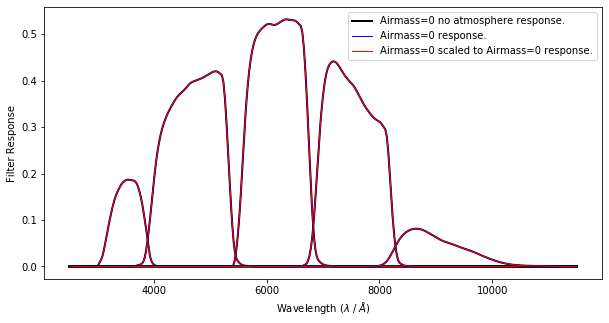

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

# filter response functions from Doi et al (2010)
# found http://classic.sdss.org/dr7/instruments/imager/index.html#filters
sdss_filters = 'Sources/utils/sdss-cfg/SDSS_Photometry/'
# bands in which to draw curves
bands = ['u','g','r','i','z']
# typical value of SDSS airmass
airmass = 0


# define wavelength grid [Angstrom]
wl = np.arange(2500,11500)
# wavelength bin widths [Angstrom]
dwl = np.median(np.diff(wl)) # [Angstrom]

# set up figure
fig,ax = plt.subplots(figsize=(10,5))
ax.set_xlabel(r'Wavelength ($\lambda$ / $\AA$)')
ax.set_ylabel('Filter Response')

# loop over each band and plot
for band in bands:
    
    filter_data = np.loadtxt(sdss_filters+'{}.dat'.format(band))
    filter_wl = filter_data[:,0]
    filter_res = filter_data[:,3]
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless
    norm_zeroair = np.trapz(filter_res,wl)
    plt.plot(wl,filter_res,color='black',linewidth=2,linestyle='solid',
            label=('Airmass=0 no atmosphere response.' if band is 'r' else None))
    
    # filter response function (w/ atmospheric effects but renormalized)
    filter_data = np.loadtxt(sdss_filters+'{}.dat'.format(band))
    filter_wl = filter_data[:,0]
    # extinction values in column 4 assume an airmass of 1.0
    kk = -2.5*np.log10(1.0*filter_data[:,4])
    correction = 10**(-0.4*(airmass*kk))
    filter_res = filter_data[:,3]*correction
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless
    norm_air = np.trapz(filter_res,wl)
    plt.plot(wl,filter_res,color='blue',linewidth=1,linestyle='solid',
            label=('Airmass={} response.'.format(airmass) if band is 'r' else None))
    
    # filter response function (w/ atmospheric effects but renormalized)
    filter_data = np.loadtxt(sdss_filters+'{}.dat'.format(band))
    filter_wl = filter_data[:,0]
    kk = -2.5*np.log10(filter_data[:,4])
    correction = 10**(-0.4*(airmass*kk))
    filter_res = filter_data[:,3]*correction*norm_zeroair/norm_air
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless
    
    plt.plot(wl,filter_res,color='red',linewidth=1,linestyle='solid',
             label=('Airmass={} scaled to Airmass=0 response.'.format(airmass) if band is 'r' else None))
    
ax.legend()
    
    

In [38]:
cfis_filters = 'Sources/utils/sdss-cfg/CFIS_Photometry/'

# datacube wavelength file path 
wl_filename = sdss_filters+'SDSS_gri3_wavelength_grid.dat'
# wavelengths of datacube [microns] (expand by redshift factor)
# wl = np.loadtxt(wl_filename).astype(float)*1e4 # [Angstrom]

# datacube wavelength file path 
wl_filename = sdss_filters+'SDSS_gri3_wavelength_grid.dat'
# wavelengths of datacube [microns] (expand by redshift factor)
# wl = np.loadtxt(wl_filename).astype(float)*1e4 # [Angstrom]


    
# # Buton et al 2013 (2013A&A...549A...8B) Median extincton in (mag/airmass)
# extinction_wl,extinction = np.loadtxt(cfis_filters+'CFIS_extinction.txt',unpack=True)

# extinction = np.interp(xp=extinction_wl,x=wl,fp=extinction,left=np.max(extinction),right=0) # unitless
# airmass = 1.25
# correction = 10**(0.4*(airmass*extinction))

#     # filter response function (w/ atmospheric effects but renormalized)
#     filter_wl,filter_res = np.loadtxt(cfis_filters+'{}_CFIS.res'.format(band),unpack=True)
#     filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0)
#     plt.plot(wl,filter_res,color='black',linewidth=2,linestyle='dashed')

#     # filter response function (w/ atmospheric effects but renormalized)
#     filter_wl,filter_res = np.loadtxt(cfis_filters+'{}_CFIS.res'.format(band),unpack=True)
#     filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0)*correction # unitless
#     plt.plot(wl,filter_res,color='black',linewidth=2)

0.856048221046688


(2500, 11500)

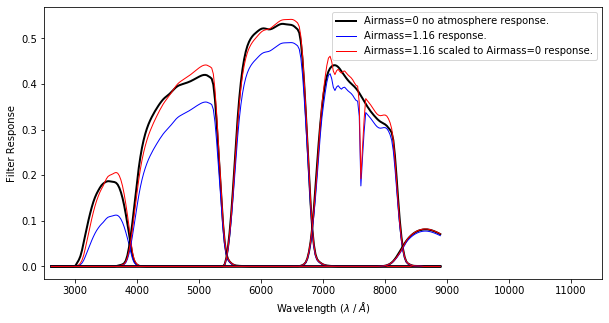

In [14]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt


# filter response functions from Doi et al (2010)
# found http://classic.sdss.org/dr7/instruments/imager/index.html#filters
sdss_filters = 'Sources/utils/sdss-cfg/SDSS_Photometry/'
# configuration path (SEx params, gim2d files, etc.)
sdss_cfg_path = 'Sources/utils/sdss-cfg/SDSS_Photometry/'
# target redshift
redshift = 0.046
airmass=1.16

# wavelength list from SKIRT
wl_filename = sdss_cfg_path+'SDSS_gri3_wavelength_grid.dat'
# bands in which to produce photometry
bands = ['u','g','r','i','z']

# useful constants / quantities
speed_of_light = 2.998e8 # [m/s]
speed_of_light = speed_of_light*1e10 # [Angstrom/s]

# wavelengths of datacube [microns] (expand by redshift factor)
wl = np.loadtxt(wl_filename).astype(float)*1e4*(1+redshift) # [Angstrom]
# wavelength bin widths [Angstrom]
dwl = np.median(np.diff(wl)) # [Angstrom]

# set up figure
fig,ax = plt.subplots(figsize=(10,5))
ax.set_xlabel(r'Wavelength ($\lambda$ / $\AA$)')
ax.set_ylabel('Filter Response')

for band in bands:

    filter_data = np.loadtxt(sdss_filters+'{}.dat'.format(band))
    filter_wl = filter_data[:,0]
    filter_res = filter_data[:,3]
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless
    norm_zeroair = np.trapz(filter_res,wl)
    plt.plot(wl,filter_res,color='black',linewidth=2,linestyle='solid',
            label=('Airmass=0 no atmosphere response.' if band is 'r' else None))
    
    # filter response function (w/ atmospheric effects but renormalized)
    filter_data = np.loadtxt(sdss_filters+'{}.dat'.format(band))
    filter_wl = filter_data[:,0]
    # extinction values in column 4 assume an airmass of 1.0
    kk = -2.5*np.log10(1.0*filter_data[:,4])
    correction = 10**(-0.4*(airmass*kk))
    filter_res = filter_data[:,3]*correction
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless
    norm_air = np.trapz(filter_res,wl)
    plt.plot(wl,filter_res,color='blue',linewidth=1,linestyle='solid',
            label=('Airmass={} response.'.format(airmass) if band is 'r' else None))
    
    # filter response function (w/ atmospheric effects but renormalized)
    filter_data = np.loadtxt(sdss_filters+'{}.dat'.format(band))
    filter_wl = filter_data[:,0]
    kk = -2.5*np.log10(filter_data[:,4])
    correction = 10**(-0.4*(airmass*kk))
    filter_res = filter_data[:,3]*correction*norm_zeroair/norm_air
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless
    
    plt.plot(wl,filter_res,color='red',linewidth=1,linestyle='solid',
             label=('Airmass={} scaled to Airmass=0 response.'.format(airmass) if band is 'r' else None))
    
ax.legend()
ax.set_xlim(2500,11500)
    
